# Evaluate YOLOv8 Detection Models
**Author:** G8  
**Task:** 3.2 - YOLOv8 Evaluation  
**Timeline:** Feb 10, 2025  

**Purpose:**
- Evaluate all 3 YOLOv8 models
- Calculate mAP50, mAP50-95, precision, recall
- Measure inference speed (FPS)
- Compare model performance

In [1]:
import os
import json
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
import time

# Enable inline plotting for Jupyter
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

print("Libraries imported!")

Libraries imported!


In [2]:
# Config
PROJECT_ROOT = Path.cwd().parent if 'notebooks' in str(Path.cwd()) else Path.cwd()
DATA_YAML = PROJECT_ROOT / "data" / "data.yaml"
MODELS_PATH = PROJECT_ROOT / "models" / "detection"
RESULTS_PATH = PROJECT_ROOT / "results" / "detection"
LOGS_PATH = PROJECT_ROOT / "logs" / "detection"

(RESULTS_PATH / 'metrics').mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'visualizations').mkdir(parents=True, exist_ok=True)
(RESULTS_PATH / 'predictions').mkdir(parents=True, exist_ok=True)

print(f"Results path: {RESULTS_PATH}")
print(f"Logs path: {LOGS_PATH}")

Results path: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/results/detection
Logs path: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/logs/detection


## Evaluate Each Model

In [3]:
def evaluate_yolo_model(variant):
    """Evaluate one YOLOv8 model"""
    print("\n" + "="*80)
    print(f"EVALUATING YOLOV8{variant.upper()}")
    print("="*80)
    
    # Load model
    model_path = MODELS_PATH / f"yolov8{variant}_best.pt"
    print(f"\nLoading: {model_path.name}")
    model = YOLO(model_path)
    
    # Run validation
    print("\nRunning validation...")
    metrics = model.val(
        data=str(DATA_YAML),
        split='test',
        save_json=True,
        conf=0.25,
        iou=0.6,
        plots=True,
        project=str(RESULTS_PATH),
        name=f'eval_{variant}',
        exist_ok=True
    )
    
    # Extract metrics
    results = {
        'model': f'yolov8{variant}',
        'mAP50': float(metrics.box.map50),
        'mAP50_95': float(metrics.box.map),
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr),
    }
    
    # Measure speed
    print("\nMeasuring inference speed...")
    test_imgs = list((PROJECT_ROOT / "data" / "multi_objects" / "images" / "test").glob("*.jpg"))
    
    if len(test_imgs) > 0:
        # Warmup
        for _ in range(5):
            _ = model(test_imgs[0], verbose=False)
        
        # Measure
        start = time.time()
        num_runs = 50
        for i in range(num_runs):
            _ = model(test_imgs[i % len(test_imgs)], verbose=False)
        elapsed = time.time() - start
        
        results['inference_fps'] = float(num_runs / elapsed)
        results['inference_ms'] = float((elapsed / num_runs) * 1000)
    
    # Model size
    results['model_size_mb'] = float(os.path.getsize(model_path) / (1024 * 1024))
    
    # Print summary
    print("\n" + "-"*80)
    print("METRICS SUMMARY")
    print("-"*80)
    print(f"mAP50:      {results['mAP50']:.4f}")
    print(f"mAP50-95:   {results['mAP50_95']:.4f}")
    print(f"Precision:  {results['precision']:.4f}")
    print(f"Recall:     {results['recall']:.4f}")
    print(f"FPS:        {results['inference_fps']:.1f}")
    print(f"Latency:    {results['inference_ms']:.2f} ms")
    print(f"Model size: {results['model_size_mb']:.2f} MB")
    
    # Save metrics
    json_path = RESULTS_PATH / 'metrics' / f"yolov8{variant}_metrics.json"
    with open(json_path, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\nMetrics saved: {json_path.name}")
    
    return results

# Evaluate all models
print("="*80)
print("EVALUATION PIPELINE")
print("="*80)

all_metrics = []
for variant in ['n', 's', 'm']:
    metrics = evaluate_yolo_model(variant)
    all_metrics.append(metrics)

EVALUATION PIPELINE

EVALUATING YOLOV8N

Loading: yolov8n_best.pt

Running validation...
Ultralytics 8.4.11 🚀 Python-3.11.14 torch-2.10.0 CPU (Apple M1)
Model summary (fused): 73 layers, 3,013,253 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.2±0.1 ms, read: 355.6±133.5 MB/s, size: 91.2 KB)
val: Scanning /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/data/multi_objects/labels/test.cache... 233 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 233/233 26.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 15/15 2.4s/it 36.7s2.7ss
                   all        233       1358      0.985      0.978      0.988      0.988
                OBJ001         80         80          1          1      0.995      0.995
                OBJ002         80         80      0.971       0.83      0.982      0.982
                OBJ003   

## Model Comparison

In [4]:
print("="*80)
print("MODEL COMPARISON")
print("="*80)

df_comp = pd.DataFrame(all_metrics)
df_comp = df_comp.sort_values('mAP50', ascending=False)
df_comp['rank'] = range(1, len(df_comp) + 1)

# Reorder
cols = ['rank', 'model', 'mAP50', 'mAP50_95', 'precision', 'recall',
        'inference_fps', 'inference_ms', 'model_size_mb']
df_comp = df_comp[cols]

print("\n" + df_comp.to_string(index=False))

# Save Excel
excel_path = RESULTS_PATH / 'metrics' / 'yolo_comparison.xlsx'
df_comp.to_excel(excel_path, index=False, sheet_name='YOLOv8_Comparison')
print(f"\nSaved: {excel_path.name}")

# Best model
best = df_comp.iloc[0]
print("\n" + "="*80)
print("BEST DETECTION MODEL")
print("="*80)
print(f"Model: {best['model']}")
print(f"mAP50: {best['mAP50']:.4f}")
print(f"FPS: {best['inference_fps']:.1f}")

MODEL COMPARISON

 rank   model    mAP50  mAP50_95  precision   recall  inference_fps  inference_ms  model_size_mb
    1 yolov8m 0.988751  0.988751   0.977005 0.985239       4.319249    231.521745      49.663591
    2 yolov8n 0.987555  0.987555   0.985039 0.977518      20.747491     48.198600       5.978678
    3 yolov8s 0.987419  0.987419   0.982606 0.980995       9.413685    106.228323      21.508768

Saved: yolo_comparison.xlsx

BEST DETECTION MODEL
Model: yolov8m
mAP50: 0.9888
FPS: 4.3


## Visualization

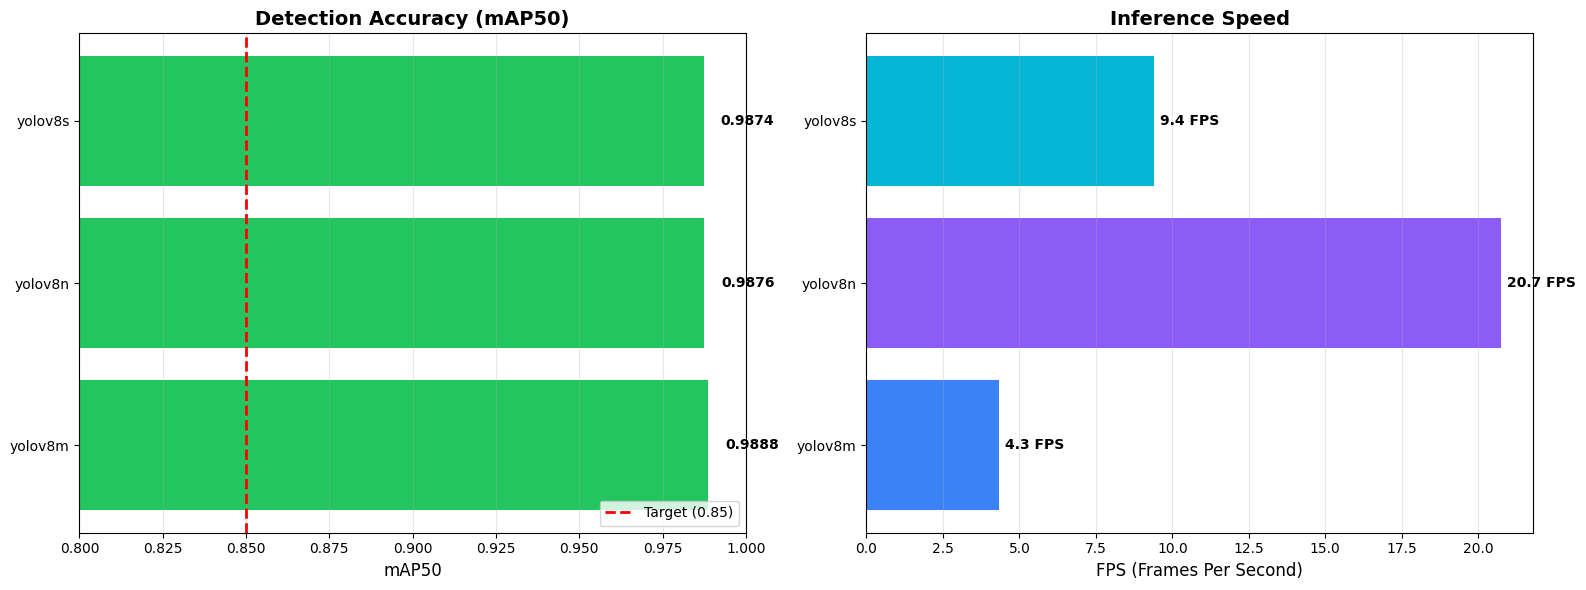


Comparison chart saved!


In [5]:
# Comparison charts
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# mAP50 comparison
ax1 = axes[0]
colors1 = ['#22c55e' if x > 0.95 else '#f59e0b' if x > 0.85 else '#ef4444' for x in df_comp['mAP50']]
bars1 = ax1.barh(df_comp['model'], df_comp['mAP50'], color=colors1)
ax1.set_xlabel('mAP50', fontsize=12)
ax1.set_title('Detection Accuracy (mAP50)', fontsize=14, fontweight='bold')
ax1.axvline(x=0.85, color='r', linestyle='--', linewidth=2, label='Target (0.85)')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3, axis='x')
ax1.set_xlim(0.8, 1.0)

for i, bar in enumerate(bars1):
    width = bar.get_width()
    ax1.text(width + 0.005, bar.get_y() + bar.get_height()/2,
             f'{width:.4f}', ha='left', va='center', fontweight='bold')

# FPS comparison
ax2 = axes[1]
colors2 = ['#3b82f6', '#8b5cf6', '#06b6d4']
bars2 = ax2.barh(df_comp['model'], df_comp['inference_fps'], color=colors2)
ax2.set_xlabel('FPS (Frames Per Second)', fontsize=12)
ax2.set_title('Inference Speed', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for i, bar in enumerate(bars2):
    width = bar.get_width()
    ax2.text(width + 0.2, bar.get_y() + bar.get_height()/2,
             f'{width:.1f} FPS', ha='left', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'metrics' / 'yolo_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nComparison chart saved!")

## Training Curves from Logs

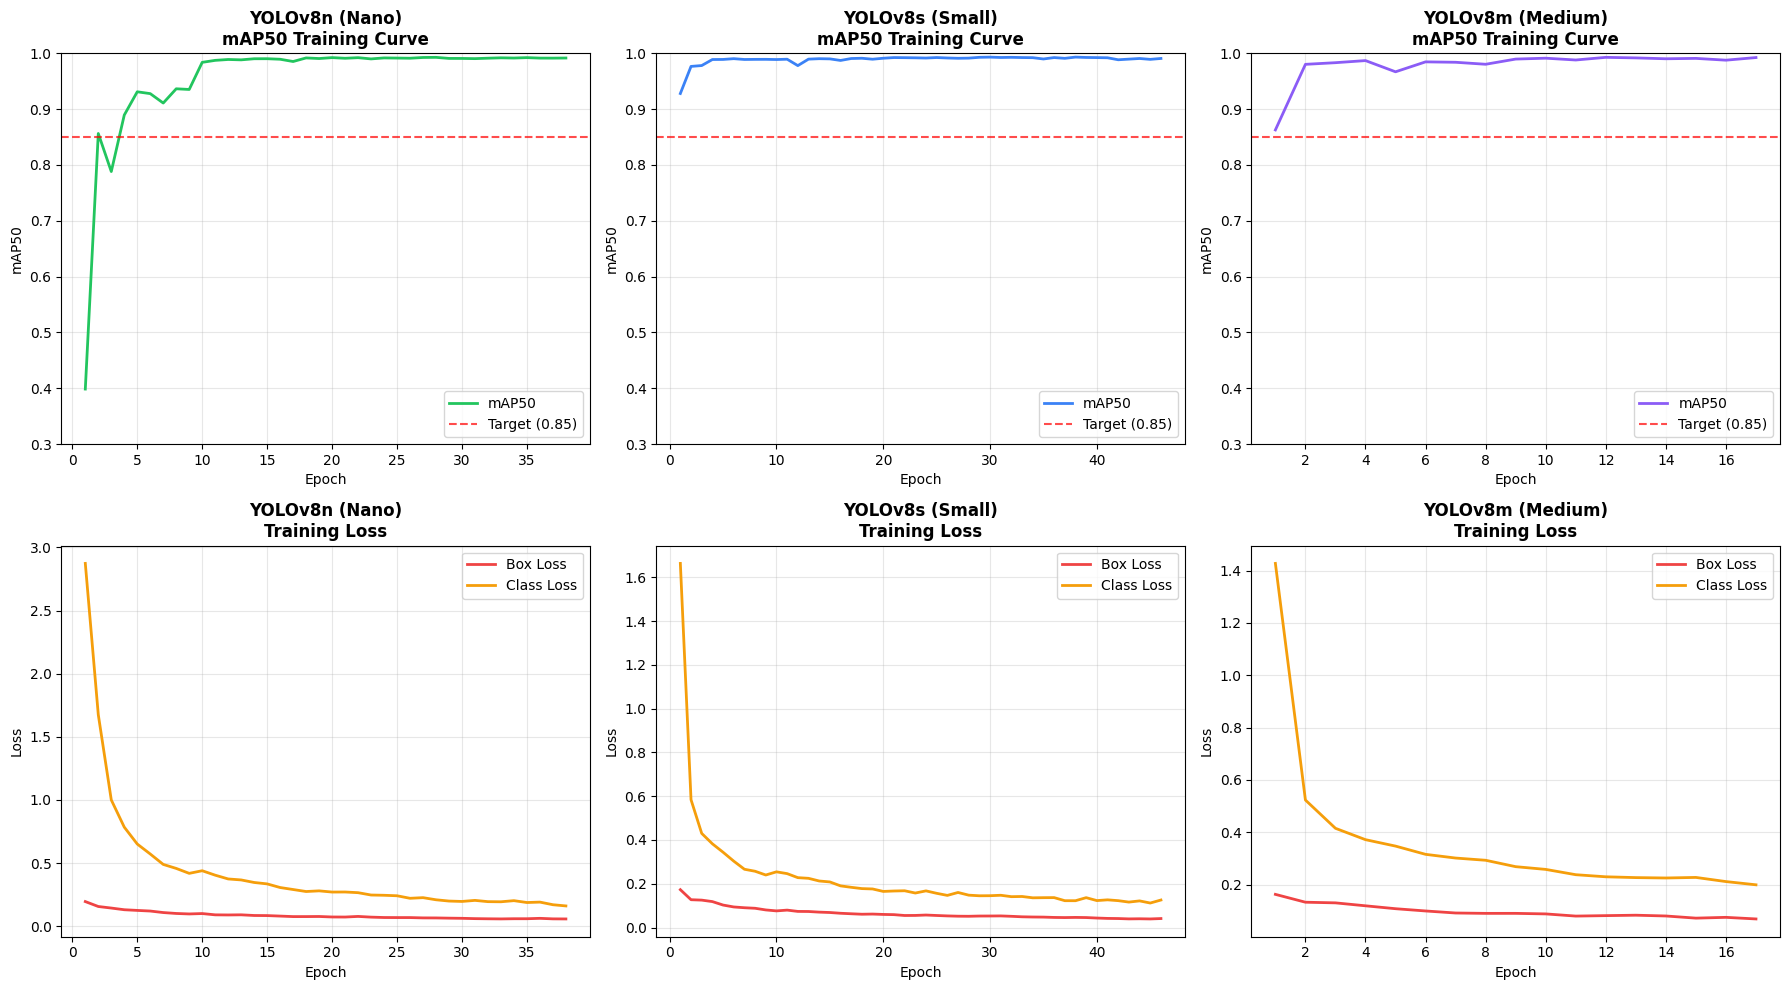


Training curves saved!


In [6]:
# Load and visualize training curves from logs
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

variants = ['n', 's', 'm']
variant_names = ['YOLOv8n (Nano)', 'YOLOv8s (Small)', 'YOLOv8m (Medium)']
colors = ['#22c55e', '#3b82f6', '#8b5cf6']

for idx, (variant, name, color) in enumerate(zip(variants, variant_names, colors)):
    log_file = LOGS_PATH / f'train_{variant}' / 'results.csv'
    
    if log_file.exists():
        df = pd.read_csv(log_file)
        df.columns = df.columns.str.strip()  # Remove whitespace from column names
        
        # mAP50 curve (top row)
        ax_map = axes[0, idx]
        ax_map.plot(df['epoch'], df['metrics/mAP50(B)'], color=color, linewidth=2, label='mAP50')
        ax_map.axhline(y=0.85, color='red', linestyle='--', alpha=0.7, label='Target (0.85)')
        ax_map.set_xlabel('Epoch', fontsize=10)
        ax_map.set_ylabel('mAP50', fontsize=10)
        ax_map.set_title(f'{name}\nmAP50 Training Curve', fontsize=12, fontweight='bold')
        ax_map.legend(loc='lower right')
        ax_map.grid(True, alpha=0.3)
        ax_map.set_ylim(0.3, 1.0)
        
        # Loss curve (bottom row)
        ax_loss = axes[1, idx]
        ax_loss.plot(df['epoch'], df['train/box_loss'], color='#ef4444', linewidth=2, label='Box Loss')
        ax_loss.plot(df['epoch'], df['train/cls_loss'], color='#f59e0b', linewidth=2, label='Class Loss')
        ax_loss.set_xlabel('Epoch', fontsize=10)
        ax_loss.set_ylabel('Loss', fontsize=10)
        ax_loss.set_title(f'{name}\nTraining Loss', fontsize=12, fontweight='bold')
        ax_loss.legend(loc='upper right')
        ax_loss.grid(True, alpha=0.3)
    else:
        axes[0, idx].text(0.5, 0.5, f'No log file for {name}', ha='center', va='center')
        axes[1, idx].text(0.5, 0.5, f'No log file for {name}', ha='center', va='center')

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'visualizations' / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTraining curves saved!")

## Confusion Matrix Visualization

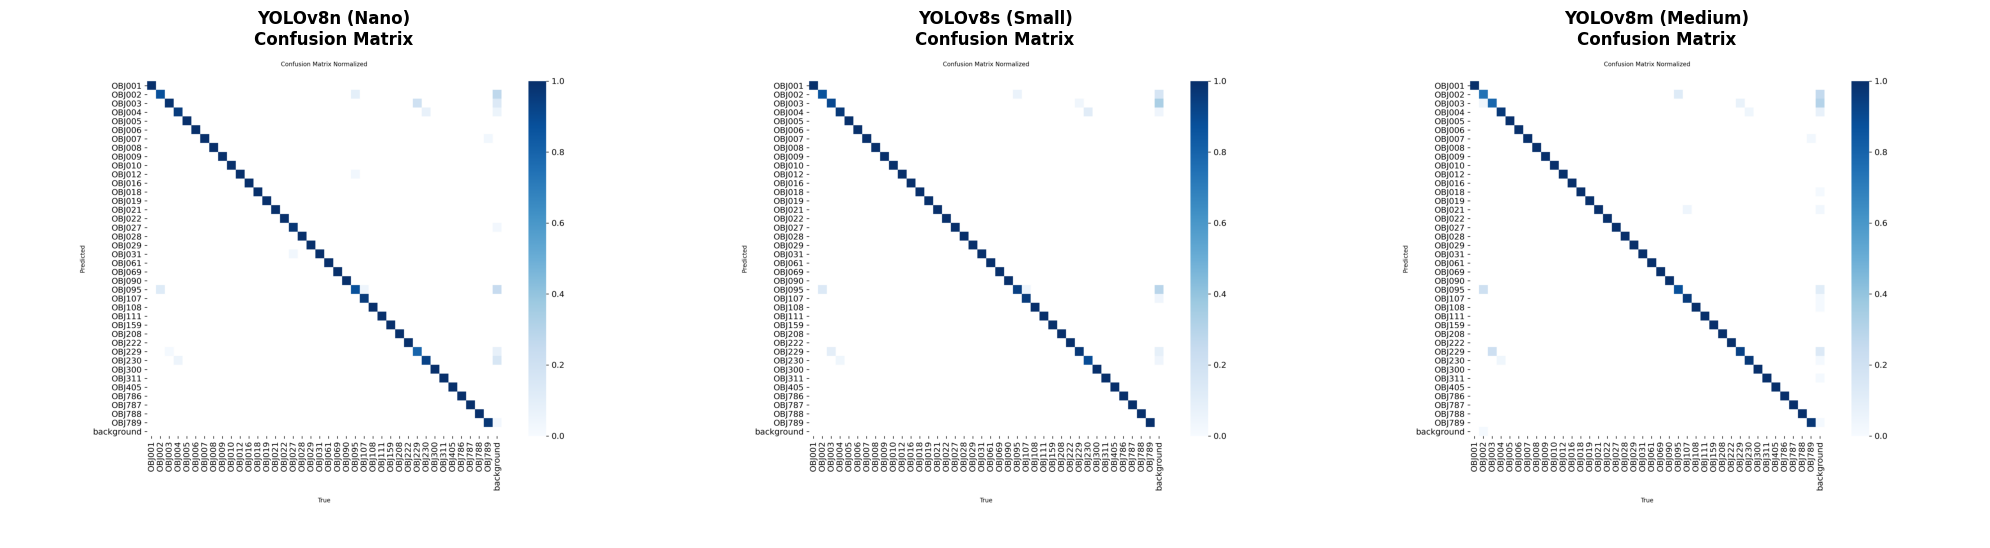


Confusion matrices saved!


In [7]:
# Display confusion matrices from training logs
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (variant, name) in enumerate(zip(variants, variant_names)):
    cm_path = LOGS_PATH / f'train_{variant}' / 'confusion_matrix_normalized.png'
    
    if cm_path.exists():
        img = mpimg.imread(cm_path)
        axes[idx].imshow(img)
        axes[idx].set_title(f'{name}\nConfusion Matrix', fontsize=12, fontweight='bold')
        axes[idx].axis('off')
    else:
        axes[idx].text(0.5, 0.5, f'No confusion matrix for {name}', ha='center', va='center')
        axes[idx].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'visualizations' / 'confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nConfusion matrices saved!")

## Sample Predictions Visualization

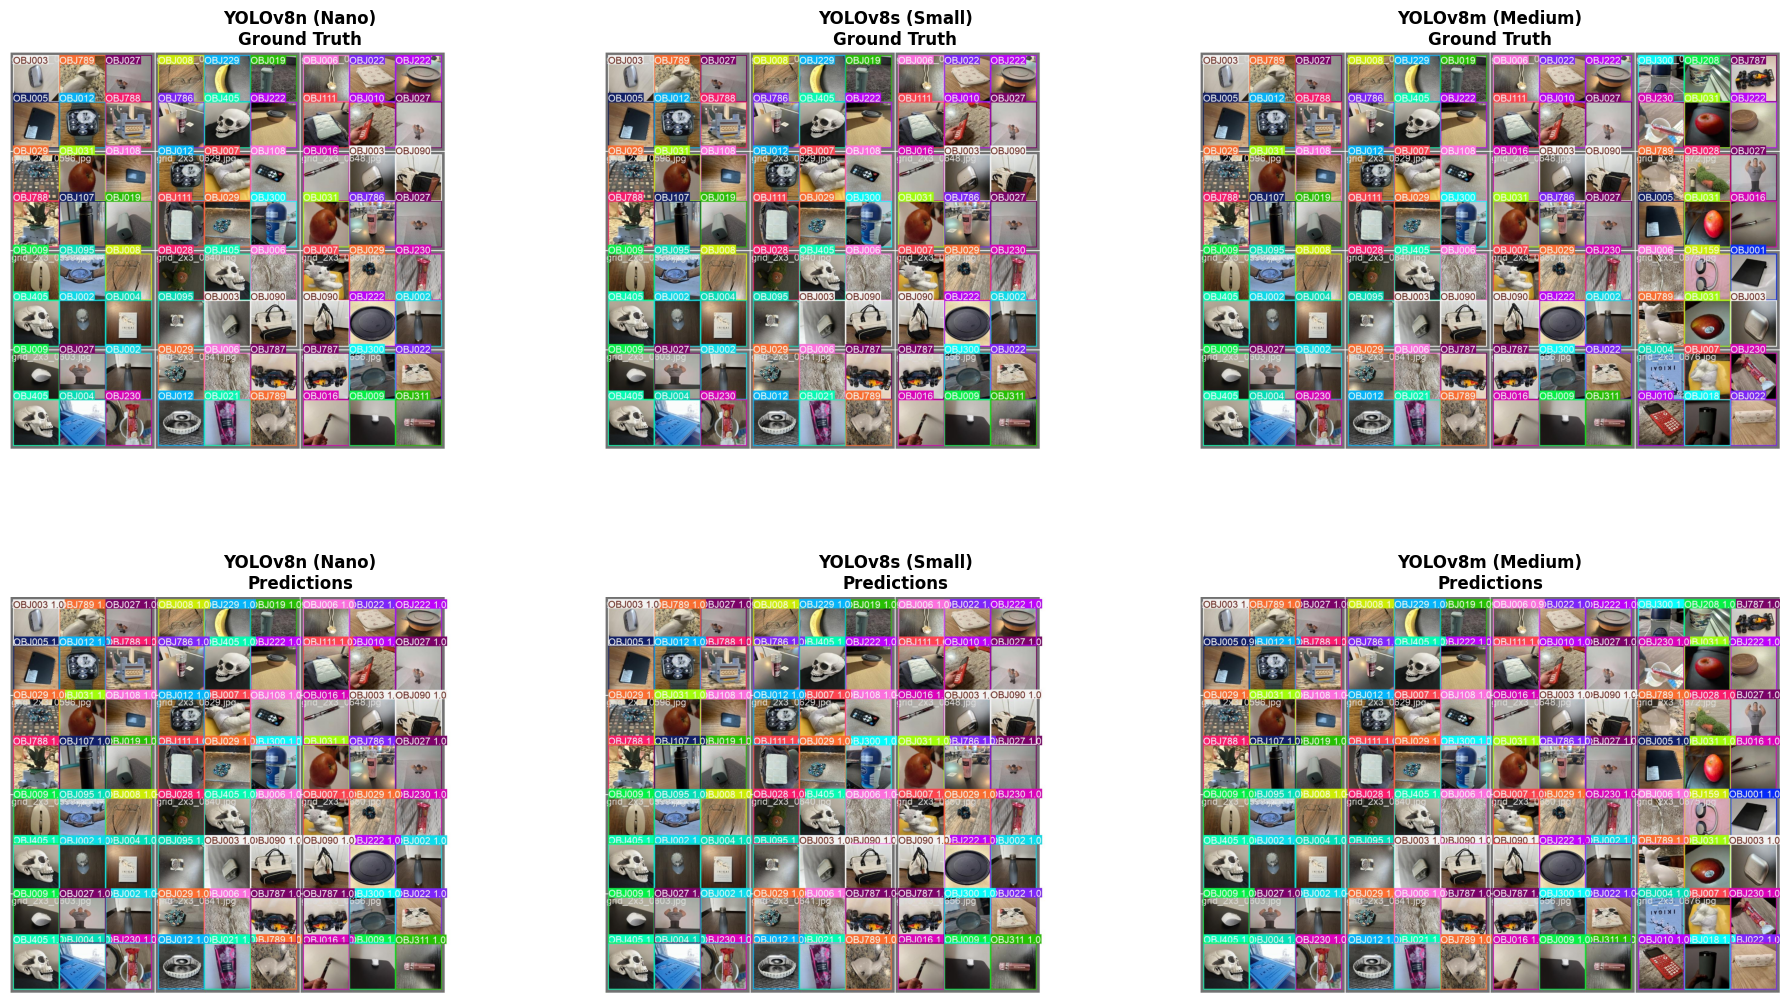


Sample predictions saved!


In [8]:
# Display sample predictions from training logs
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for idx, (variant, name) in enumerate(zip(variants, variant_names)):
    # Labels (ground truth)
    labels_path = LOGS_PATH / f'train_{variant}' / 'val_batch0_labels.jpg'
    # Predictions
    preds_path = LOGS_PATH / f'train_{variant}' / 'val_batch0_pred.jpg'
    
    # Top row: Ground Truth Labels
    if labels_path.exists():
        img_labels = mpimg.imread(labels_path)
        axes[0, idx].imshow(img_labels)
        axes[0, idx].set_title(f'{name}\nGround Truth', fontsize=12, fontweight='bold')
    else:
        axes[0, idx].text(0.5, 0.5, 'No labels image', ha='center', va='center')
    axes[0, idx].axis('off')
    
    # Bottom row: Model Predictions
    if preds_path.exists():
        img_preds = mpimg.imread(preds_path)
        axes[1, idx].imshow(img_preds)
        axes[1, idx].set_title(f'{name}\nPredictions', fontsize=12, fontweight='bold')
    else:
        axes[1, idx].text(0.5, 0.5, 'No predictions image', ha='center', va='center')
    axes[1, idx].axis('off')

plt.tight_layout()
plt.savefig(RESULTS_PATH / 'visualizations' / 'sample_predictions.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nSample predictions saved!")

## Summary

In [9]:
print("="*80)
print("EVALUATION COMPLETE")
print("="*80)
print("\nFiles saved:")
print(f"  - Metrics JSON: {RESULTS_PATH / 'metrics'}")
print(f"  - Comparison Excel: {RESULTS_PATH / 'metrics' / 'yolo_comparison.xlsx'}")
print(f"  - Visualizations: {RESULTS_PATH / 'visualizations'}")
print("\n" + "="*80)
print("FINAL RESULTS")
print("="*80)
print(df_comp[['model', 'mAP50', 'precision', 'recall', 'inference_fps']].to_string(index=False))
print(f"\nBest Model: {df_comp.iloc[0]['model']} with mAP50 = {df_comp.iloc[0]['mAP50']:.4f}")
print(f"Fastest Model: {df_comp.loc[df_comp['inference_fps'].idxmax(), 'model']} with {df_comp['inference_fps'].max():.1f} FPS")

EVALUATION COMPLETE

Files saved:
  - Metrics JSON: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/results/detection/metrics
  - Comparison Excel: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/results/detection/metrics/yolo_comparison.xlsx
  - Visualizations: /Users/kevin/Documents/GitHub/Python/VESKL/11.DAE/NEU/NEU_IE7615/Prj/Discriminative/G8/Project1/IE7615_Discriminative_Project/results/detection/visualizations

FINAL RESULTS
  model    mAP50  precision   recall  inference_fps
yolov8m 0.988751   0.977005 0.985239       4.319249
yolov8n 0.987555   0.985039 0.977518      20.747491
yolov8s 0.987419   0.982606 0.980995       9.413685

Best Model: yolov8m with mAP50 = 0.9888
Fastest Model: yolov8n with 20.7 FPS
